# Insider Threat
----

# Long-range Forecasting and Pattern Discovery given Limited Data

In [77]:
# %load setup_bayes.py
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
# import theano
# import theano.tensor as tt
# import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
# from bqplot import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
# from beakerx import *
sns.set_context('notebook', font_scale = 1.1)
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 'lines.linewidth': 2.0, 
      'lines.markersize': 8, 'font.family': "serif", 'font.serif': "cm", 'savefig.dpi': 200,
      'text.usetex': False, 'legend.fontsize': 20.0, 'axes.titlesize': 20, "figure.figsize": [20, 12]}
sns.set(rc = rc)
sns.set_style("ticks")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gpflow
from gpflowopt.domain import ContinuousParameter
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.acquisition import ExpectedImprovement, MinValueEntropySearch
from gpflowopt.optim import StagedOptimizer, MCOptimizer, SciPyOptimizer  
from gpflowopt.design import LatinHyperCube
import random
random.seed(1234)
from warnings import filterwarnings
filterwarnings("ignore")

## Data Preparation

In [78]:
email_filtered = pd.read_csv("../../data/email_filtered.csv", parse_dates=["date"])

In [79]:
email_filtered.head()      

In [80]:
email_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11920 entries, 0 to 11919
Data columns (total 12 columns):
id             11920 non-null object
date           11920 non-null datetime64[ns]
user           11920 non-null object
pc             11920 non-null object
to             11920 non-null object
cc             6101 non-null object
bcc            593 non-null object
from           11920 non-null object
activity       11920 non-null object
size           11920 non-null int64
attachments    3809 non-null object
content        11920 non-null object
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 1.1+ MB


Let's select one user in particular who is a known insider.


In [81]:
# The insider
df_insider = email_filtered[email_filtered["user"] == "CDE1846"]
df_insider.head()
df_insider.shape

(3165, 12)

In [107]:
emails_per_month = df_insider.resample(rule = "1M", on = "date").sum().reset_index()
emails_per_month["date"] = pd.to_datetime(emails_per_month["date"], format = "%Y-%m-%d")
emails_per_month.columns = ["ds", "y"]
emails_per_month

In [83]:
emails_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


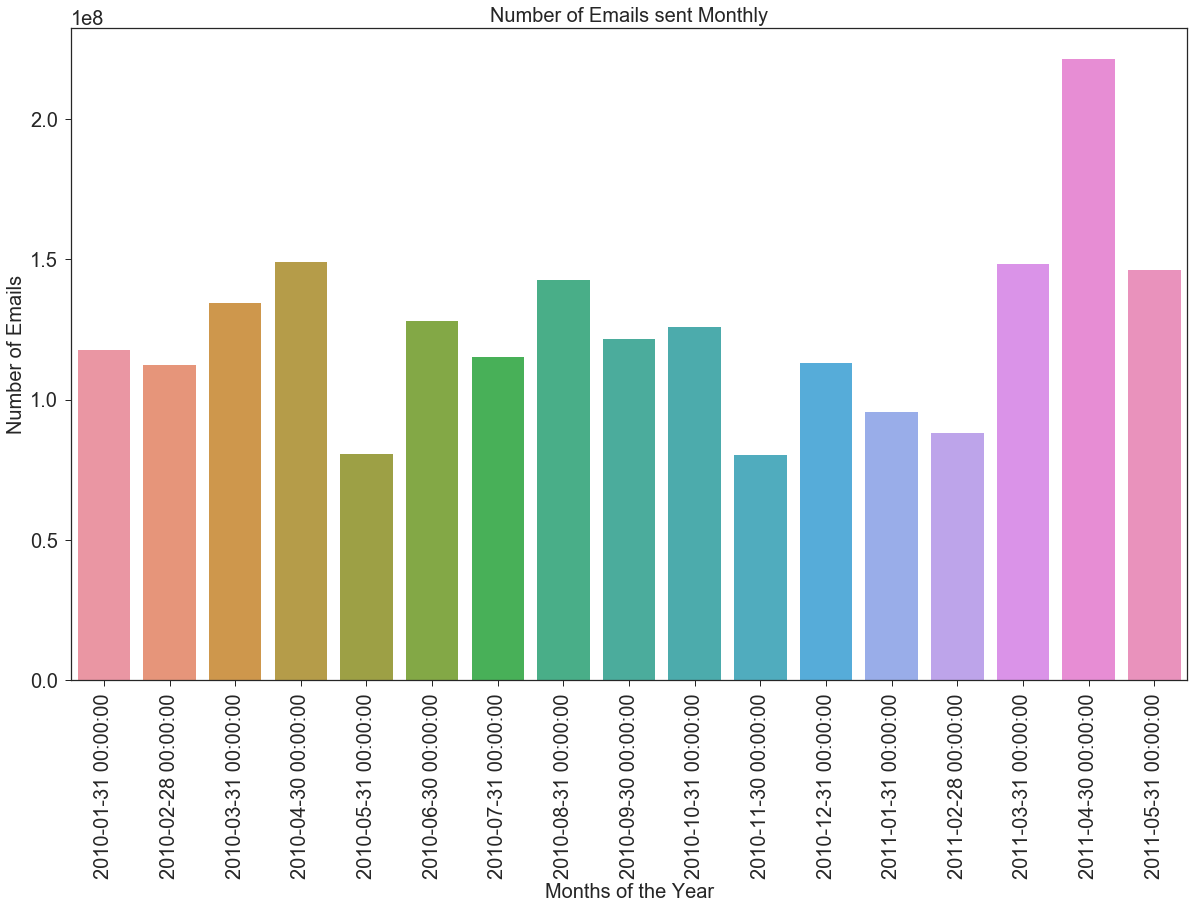

In [84]:
fig, ax = plt.subplots()
sns.barplot(data = emails_per_month, x = "ds", y = "y", ax = ax)
ax.set_xticklabels(labels = emails_per_month["ds"], rotation = 90)
ax.set_xlabel("Months of the Year")
ax.set_ylabel("Number of Emails")
ax.set_title("Number of Emails sent Monthly");

In [85]:
df_insider_non_org = df_insider[~df_insider['to'].str.contains('dtaa.com')]
df_insider_non_org

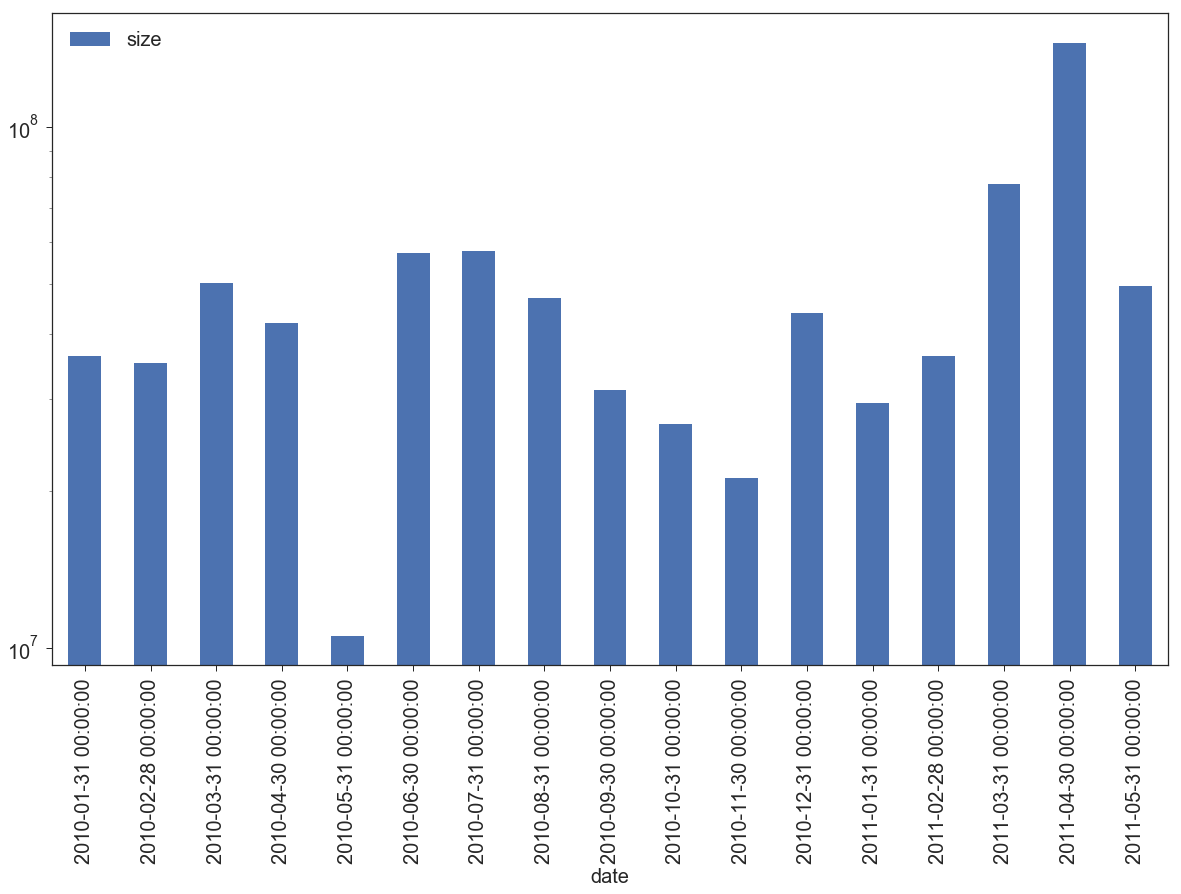

In [86]:
df_insider_non_org.resample(rule = "1M", on = "date").sum().plot(kind = "bar", logy = "size");

In [111]:
df = df_insider_non_org.resample(rule = "1M", on = "date").sum().reset_index()
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")
df.columns = ["ds", "y"]
df = df.drop([14, 15, 16])
(df.y/1e6).describe()
df.y = df.y/1e6

count    14.000000
mean     37.520015
std      13.378321
min      10.561653
25%      29.922378
50%      36.296858
75%      46.123377
max      57.778657
Name: y, dtype: float64

Explore Insider Threat Case

In [87]:
# Here, we look at the case where the insider email IP to their home account
# The data is resampled per month and the anomalous behavior is clearly
# visible
df_insider_ewing = df_insider_non_org[df_insider_non_org['to'] == 'Ewing_Carlos@comcast.net']
df = df_insider_ewing.resample('1M', on='date').sum().reset_index()
df.columns = ["ds", "y"]
(df.y/1e6).describe()
df.y = df.y/1e6

count     17.000000
mean      13.042668
std       27.010948
min        0.181588
25%        2.258068
50%        4.749784
75%        6.430011
max      108.623858
Name: y, dtype: float64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
ds    17 non-null datetime64[ns]
y     17 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 352.0 bytes


In [89]:
df

In [90]:
from datetime import datetime
df["ds"] = df.apply(lambda x: datetime.date(x["ds"]), axis = 1)

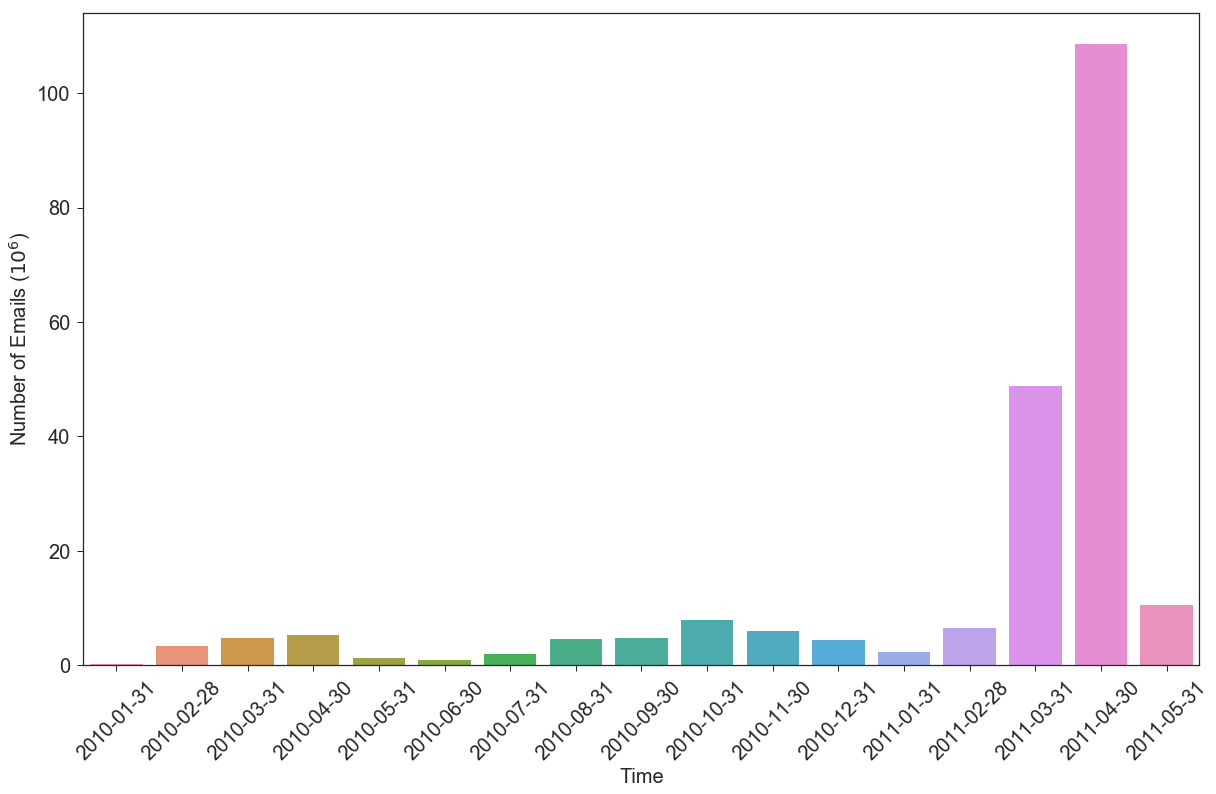

In [91]:
fig, ax = plt.subplots()
sns.barplot(data = df, x = "ds", y = "y")
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Emails ($10^6$)");
# ax.set_title("Number of Emails sent Monthly");

In [92]:
df = df.drop([14, 15, 16])

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 2 columns):
ds    14 non-null object
y     14 non-null float64
dtypes: float64(1), object(1)
memory usage: 336.0+ bytes


In [94]:
df

In [95]:
df.describe()

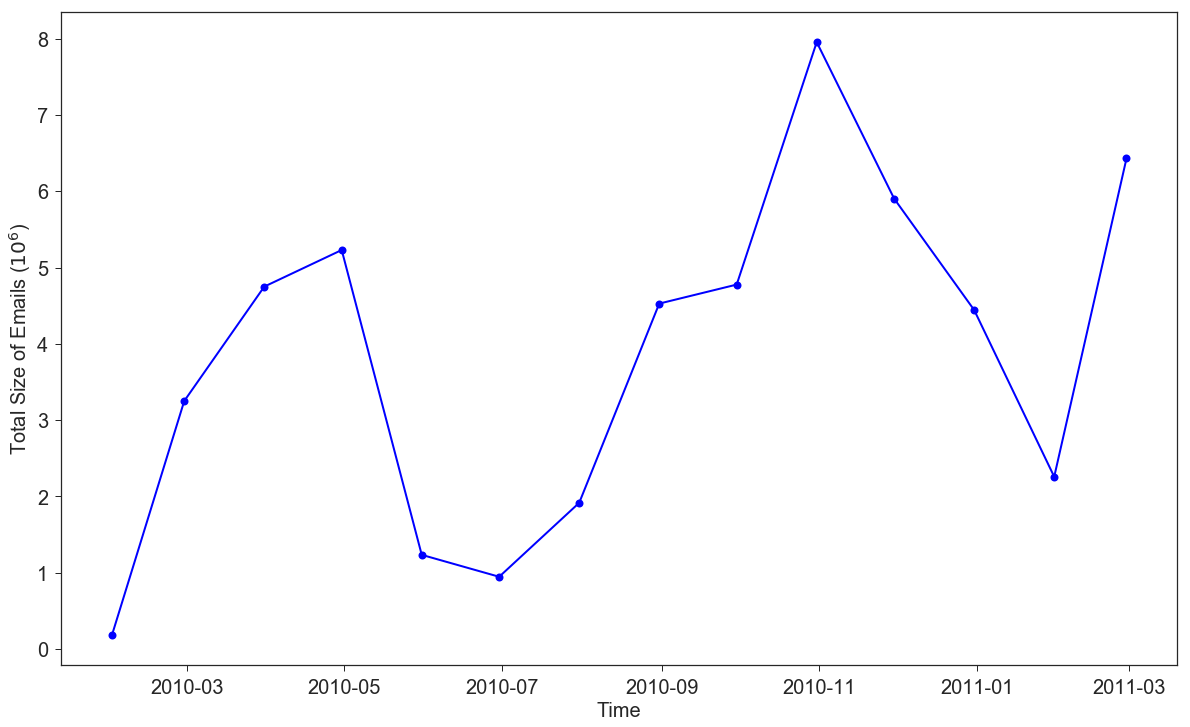

In [96]:
fig, ax = plt.subplots()
ax.plot(df.ds, df.y, color = "b", marker = "o")
# ax.set_xticklabels(labels = injury_crash_data.ds, rotation = 45)
ax.set_xlabel("Time")
ax.set_ylabel("Total Size of Emails ($10^6$)");
# ax.set_title("Number of Emails sent Monthly");

In [97]:
X_complete = np.array([df.index]).reshape((df.shape[0], 1)).astype('float64')
X_train = X_complete[0:10, ]
X_test = X_complete[10:df.shape[0], ]
Y_complete = np.array([df.y]).reshape((df.shape[0], 1)).astype('float64')
Y_train = Y_complete[0:10, ]
Y_test = Y_complete[10:df.shape[0], ]
D = Y_train.shape[1];

In [98]:
D

1

In [99]:
Y_train.shape; X_train.shape; Y_test.shape; X_test.shape; X_complete.shape

(10, 1)

(10, 1)

(4, 1)

(4, 1)

(14, 1)

In [100]:
Y_train; X_train; Y_test; X_test; X_complete

array([[ 0.181588],
       [ 3.250489],
       [ 4.749784],
       [ 5.229758],
       [ 1.234118],
       [ 0.946767],
       [ 1.91637 ],
       [ 4.527464],
       [ 4.7766  ],
       [ 7.954557]])

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.],
       [ 6.],
       [ 7.],
       [ 8.],
       [ 9.]])

array([[ 5.903088],
       [ 4.442788],
       [ 2.258068],
       [ 6.430011]])

array([[ 10.],
       [ 11.],
       [ 12.],
       [ 13.]])

array([[  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.]])

In [101]:
np.sort(Y_complete.flatten())

array([ 0.181588,  0.946767,  1.234118,  1.91637 ,  2.258068,  3.250489,
        4.442788,  4.527464,  4.749784,  4.7766  ,  5.229758,  5.903088,
        6.430011,  7.954557])

In [102]:
Y_train.dtype

dtype('float64')

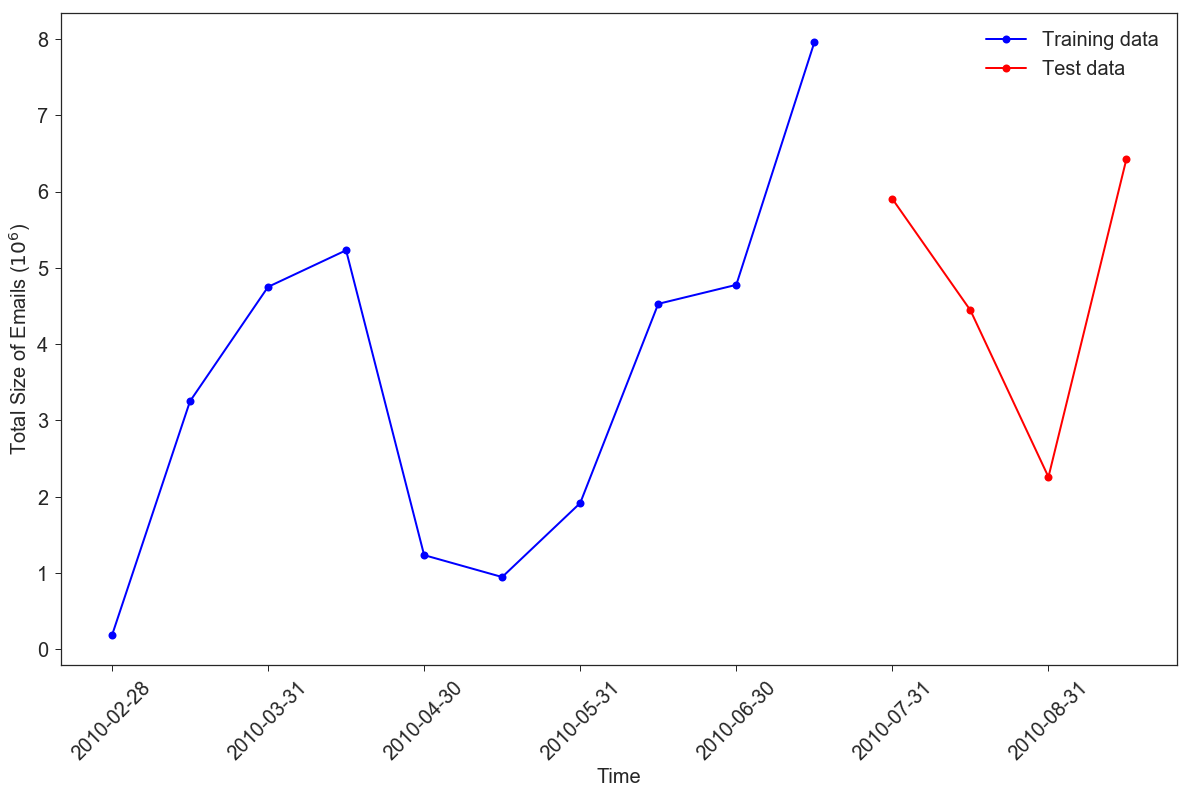

In [103]:
fig, ax = plt.subplots()
ax.plot(X_train.flatten(),Y_train.flatten(), c ='b', marker = "o", label = "Training data")
ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
ax.set_xticklabels(labels = df.ds, rotation = 45)
ax.set_xlabel('Time')
ax.set_ylabel('Total Size of Emails ($10^6$)')
plt.legend(loc = "best")
plt.savefig('results/emails/data-email.png');
# fig1 = plt.gcf()
# py.offline.iplot_mpl(fig1);

## Gaussian Process modeling

This study used a Gaussian Process model with a Spectral Mixture (SM) kernel proposed by Wilson (2014). This is because the SM kernel is capable of capturing hidden structure with data without hard cording features in a kernel. Moreover, the SM kernel is capable of performing long-range extrapolation beyond available data.


In [59]:
# Trains a model with a spectral mixture kernel, given an ndarray of 
# 2Q frequencies and lengthscales

Q = 10 # nr of terms in the sum
max_iters = 1000

def create_model(hypers):
    f = np.clip(hypers[:Q], 0, 5)
    weights = np.ones(Q) / Q
    lengths = hypers[Q:]

    kterms = []
    for i in range(Q):
        rbf = gpflow.kernels.RBF(D, lengthscales=lengths[i], variance=1./Q)
        rbf.lengthscales.transform = gpflow.transforms.Exp()
        cos = gpflow.kernels.Cosine(D, lengthscales=f[i])
        kterms.append(rbf * cos)

    k = np.sum(kterms) + gpflow.kernels.Linear(D) + gpflow.kernels.Bias(D)
    m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
    return m

m = create_model(np.ones((2*Q,)))

In [60]:
%%time
m.optimize(maxiter = max_iters)

CPU times: user 14.1 s, sys: 614 ms, total: 14.7 s
Wall time: 14.2 s


      fun: 19.723244087471944
 hess_inv: <43x43 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.20816619e-07,   3.66539077e-05,  -3.61998668e-05,
        -6.49271119e-06,  -1.08959182e-08,  -1.19118052e-05,
        -3.61998668e-05,  -6.49271119e-06,  -1.08959182e-08,
        -1.19118052e-05,  -3.61998668e-05,  -6.49271119e-06,
        -1.08959182e-08,  -1.19118052e-05,  -3.61998668e-05,
        -6.49271119e-06,  -1.08959182e-08,  -1.19118052e-05,
        -3.61998668e-05,  -6.49271119e-06,  -1.08959182e-08,
        -1.19118052e-05,  -3.61998668e-05,  -6.49271119e-06,
        -1.08959182e-08,  -1.19118052e-05,  -3.61998668e-05,
        -6.49271119e-06,  -1.08959182e-08,  -1.19118052e-05,
        -3.61998668e-05,  -6.49271119e-06,  -1.08959182e-08,
        -1.19118052e-05,  -3.61998668e-05,  -6.49271119e-06,
        -1.08959182e-08,  -1.19118052e-05,  -3.61998668e-05,
        -6.49271119e-06,  -1.08959182e-08,  -1.19118052e-05,
        -3.00233154e-05])
  message: b'CONVERGE

In [61]:
def plotprediction(m):
    # Perform prediction
    mu, var = m.predict_f(X_complete)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticklabels(labels = df.ds, rotation = 45)
    ax.set_xlabel('Time')
    ax.set_ylabel('Total Size of Emails ($10^6$)');
    ax.plot(X_train.flatten(),Y_train.flatten(), c='b', marker = "o", label = 'Training data')
    ax.plot(X_test.flatten(),Y_test.flatten(), c='r', marker = "o", label = 'Test data')
    ax.plot(X_complete.flatten(), mu.flatten(), c='g', marker = "o", label = "Predicted mean function")
    lower = mu - 2*np.sqrt(var)
    upper = mu + 2*np.sqrt(var)
    ax.plot(X_complete, upper, 'g--', X_complete, lower, 'g--', lw=1.2)
    ax.fill_between(X_complete.flatten(), lower.flatten(), upper.flatten(),
                    color='g', alpha=.1, label = "95% Predicted credible interval")
    plt.legend(loc = "best")
    plt.tight_layout()

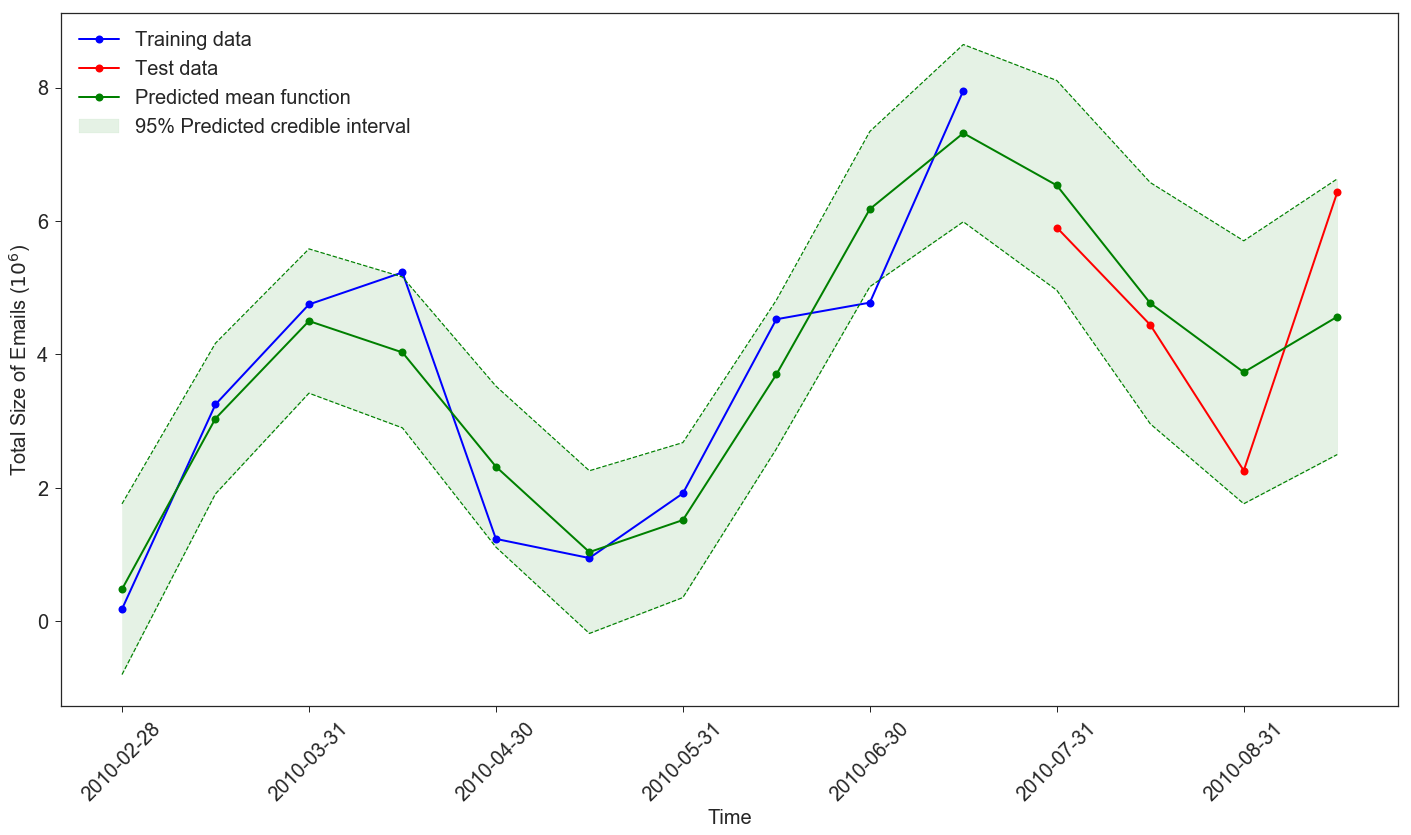

In [62]:
plotprediction(m)
plt.savefig('results/emails/model-emails.png');

In [63]:
## Calculate the RMSE and MAPE
def calculate_rmse(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    rmse = np.sqrt(((mu - Y_test)**2).mean())
    return rmse

def calculate_mape(model, X_test, Y_test):
    mu, var = model.predict_y(X_test)
    mape = (np.absolute(((mu - Y_test)/Y_test)*100)).mean()
    return mape

In [65]:
calculate_rmse(model=m, X_test = X_test, Y_test = Y_test)

1.2404664781310966

## Perform hyperparameter tuning using Bayesian Optimization

Let's use Bayesian Optimization to find the optimal model parameters of the GP model and then use then to estimate the model and prediction.

In [66]:
from gpflowopt.objective import batch_apply

# Objective function for our optimization
# Input: N x 2Q ndarray, output: N x 1.
# returns the negative log likelihood obtained by training with given frequencies and rbf lengthscales
# Applies some tricks for stability similar to GPy's jitchol
@batch_apply
def objectivefx(freq):
    m = create_model(freq)
    for i in [0] + [10**exponent for exponent in range(6,1,-1)]:
        try:
            mean_diag = np.mean(np.diag(m.kern.compute_K_symm(X_train)))
            m.likelihood.variance = 1 + mean_diag * i
            m.optimize(maxiter=max_iters)
            return -m.compute_log_likelihood()
        except:
            pass
    raise RuntimeError("Frequency combination failed indefinately.")

# Setting up optimization domain.
lower = [0.]*Q
upper = [5.]*int(Q)
df = np.sum([ContinuousParameter('freq{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])

lower = [1e-5]*Q
upper = [300]*int(Q)
dl = np.sum([ContinuousParameter('l{0}'.format(i), l, u) for i, l, u in zip(range(Q), lower, upper)])
domain = df + dl
domain

Name,Type,Values
freq0,Continuous,[ 0. 5.]
freq1,Continuous,[ 0. 5.]
freq2,Continuous,[ 0. 5.]
freq3,Continuous,[ 0. 5.]
freq4,Continuous,[ 0. 5.]
freq5,Continuous,[ 0. 5.]
freq6,Continuous,[ 0. 5.]
freq7,Continuous,[ 0. 5.]
freq8,Continuous,[ 0. 5.]
freq9,Continuous,[ 0. 5.]


In [67]:
%%time
design = LatinHyperCube(6, domain)
X = design.generate()

CPU times: user 2min 57s, sys: 27.7 s, total: 3min 25s
Wall time: 3min 31s


In [68]:
%%time
Y = objectivefx(X)

CPU times: user 5min 59s, sys: 8.33 s, total: 6min 7s
Wall time: 6min 5s


In [69]:
%%time
k_surrogate = gpflow.kernels.Matern52(input_dim = domain.size, ARD = False)

CPU times: user 190 µs, sys: 71 µs, total: 261 µs
Wall time: 267 µs


In [70]:
%%time
model_surrogate = gpflow.gpr.GPR(X, Y, kern = k_surrogate)

CPU times: user 350 µs, sys: 144 µs, total: 494 µs
Wall time: 467 µs


In [71]:
%%time
acq_fn = ExpectedImprovement(model_surrogate)
# acq_fn = MinValueEntropySearch(model_surrogate, domain = domain)

CPU times: user 1min 58s, sys: 5.6 s, total: 2min 4s
Wall time: 2min 5s


In [72]:
%%time
acq_optimizer = StagedOptimizer([MCOptimizer(domain, nsamples = 5000), 
                                SciPyOptimizer(domain)])

CPU times: user 1.6 ms, sys: 3.53 ms, total: 5.13 ms
Wall time: 6.89 ms


In [73]:
%%time
optimizer = BayesianOptimizer(domain = domain, 
                              acquisition = acq_fn, 
                              optimizer = acq_optimizer)

CPU times: user 27.9 s, sys: 1.27 s, total: 29.1 s
Wall time: 29.2 s


In [ ]:
%%time
with optimizer.silent():
    result = optimizer.optimize(objectivefx = objectivefx, n_iter = 30)

In [ ]:
print(result)

In [ ]:
%%time
m_opt = create_model(result.x[0,:])
m_opt.optimize()

In [ ]:
plotprediction(m_opt)
plt.savefig('results/emails/model-opt-emails.png');

In [ ]:
## Inspect the evolution
f, axes = plt.subplots()
f = acq_fn.data[1][:,0]
axes.plot(np.arange(0, acq_fn.data[0].shape[0]), np.minimum.accumulate(f))
axes.set_ylabel('fmin')
axes.set_xlabel('Number of evaluated points')
plt.savefig('results/emails/iterations-email.png');

In [ ]:
# # save the model and results to the files 'model.pkl' model_optimized.pkl'
# # and 'results.pkl' for later use
# with open('results/emails/model2.pkl', 'wb') as mdl:
#     pickle.dump(m, mdl, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('results/emails/model_optimized2.pkl', 'wb') as mdl_opt:
#     pickle.dump(m_opt, mdl_opt, protocol = pickle.HIGHEST_PROTOCOL)    
    
# with open('results/emails/result_optimized2.pkl', 'wb') as res:
#     pickle.dump(result, res, protocol = pickle.HIGHEST_PROTOCOL) 
    
# with open('results/emails/acq_fn2.pkl', 'wb') as acq:
#     pickle.dump(acq_fn, acq, protocol = pickle.HIGHEST_PROTOCOL)     

In [ ]:
# load it at some future point
with open('results/emails/model3.pkl', 'rb') as mdl:
    m = pickle.load(mdl)

with open('results/emails/model_optimized3.pkl', 'rb') as mdl_opt:
    m_opt = pickle.load(mdl_opt)
    
with open('results/emails/result_optimized3.pkl', 'rb') as res:
    result = pickle.load(res)   
    
with open('results/emails/acq_fn3.pkl', 'rb') as acq:
    acq_fn = pickle.load(acq)       

In [30]:
# improve quality of figures for journal paper
%config InlineBackend.figure_format = "retina" 

In [41]:
# print system information/setup
%reload_ext watermark
%watermark -v -m -p numpy,pandas,gpflowopt,gpflow,tensorflow,matplotlib,ipywidgets,beakerx,seaborn -g

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.20.3
gpflowopt 0.1.0
gpflow 0.4.0
tensorflow 1.4.1
matplotlib 2.1.1
ipywidgets 7.1.1
beakerx 0.12.1
seaborn 0.8.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.3.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ec4acbc8fd100b0026f5bfc545a6efeb4a191b89
